In [1]:
# importing all the libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid
import copy
import random
import pandas as pd
import math
import scipy
from scipy.stats import norm, expon
from scipy.linalg import null_space
import pandas as pd

import os
cwd = os.getcwd()

#importing the functions in functions_MCMC.py
%run ../functions_MCMC

In [2]:
# define variables
data_seed = 1223
burnin = 10000 #10k
n_after_burnin = 10000 #10k
delta_t = 0.3

#T=60 gives 200 delta_y
T = 60
n_chains = 4
n_sim = 1

V_F = 2000
V_B = -1500
V = np.array([V_F, V_B])
Lambda = np.array([1, 0.5])
log_Lambda = np.log(Lambda)
P = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma = 50.0
n = Lambda.shape[0]
n_param = 5

parameter_names = ['v1', 'v2', 'loglambda1', 'loglambda2', 'sigma']
parameter_names_tex = [r'$v_1$', r'$v_2$', r'log($\lambda_1$)',
                       r'log($\lambda_2$)', r'$\sigma$']

#choose initial covariance matrix for resampling
init_cov_matrix = np.array([np.diag(np.array([0.1, 0.1, 0.0001, 0.0001, 0.01]))
                            for _ in range(n_chains)])

correlated = True
up_to_switches = 1
track = True

plots = False
save = True
all_plots = False
plot_posteriors_grid = True
plot_fit = False
plot_fit_median = True

theta_true = list(V) + list(log_Lambda) + [sigma] #not including values for P for 2x2

In [3]:
#THIS STILL NEEDS TO BE MODIFIED FOR SEVERAL CASES
def get_parameters(theta):
    V = np.zeros(2)
    V[0] = 1.0*theta[0]
    V[1] = 1.0*theta[1]
    Lambda = 1.0*np.exp(np.array(theta[2:4]))
    P = np.zeros((2,2))
    P[0,1] = 1.0
    P[1,0] = 1.0
    sigma = 1.0*theta[-1]
    
    return V, Lambda, P, sigma

def q(theta, cov_matrix=init_cov_matrix):
    """q samples a new theta_star given theta"""
    theta_star = np.random.multivariate_normal(theta, cov_matrix)
    while (theta_star[0]<0 or theta_star[0]>2.0*V_F or 
           theta_star[1]>0 or theta_star[1]<2.0*V_B or 
           np.any(theta_star[2:4]<-4) or np.any(theta_star[2:4]>4) or
           theta_star[-1]<0 or np.any(theta_star[-1]>2.0*sigma)):
        theta_star = np.random.multivariate_normal(theta, cov_matrix)
    return theta_star

def theta_init_uniform(seed):
    np.random.seed(seed)
    rand_vec = np.random.uniform(size=5)
    theta = ((np.array([2.0*V_F, 2.0*V_B, 8.0, 8.0, 2.0*sigma])*rand_vec)
              +np.array([0.0, 0.0, -4.0, -4.0, 0.0]))
    #print('theta_init =', get_parameters(theta))
    return theta

In [4]:
#importing the results of the inference for track=True
#uses the joint track likelihood
#generated using run_inference_fig2.ipynb (folder related to Figure 2)
theta_all = []
for param in parameter_names:
    theta_all += [np.array(pd.read_csv("track/MCMC, parameter "+param+", burnin=10000, n_after_burnin=10000", index_col=0)).flatten()]
theta_all = np.array(theta_all)

log_pi = np.array(pd.read_csv("track/MCMC, log_pi , burnin=10000, n_after_burnin=10000", index_col=0)).flatten()
theta_best = theta_all[:, np.argmax(log_pi)]

In [5]:
#importing the results of the inference for track=False
#uses the marginal likelihood
NOT_track_theta_all = []
for param in parameter_names:
    NOT_track_theta_all += [np.array(pd.read_csv("NOT_track/MCMC, parameter "+param+", burnin=10000, n_after_burnin=10000", index_col=0)).flatten()]
NOT_track_theta_all = np.array(NOT_track_theta_all)

NOT_track_log_pi = np.array(pd.read_csv("NOT_track/MCMC, log_pi , burnin=10000, n_after_burnin=10000", index_col=0)).flatten()
NOT_track_theta_best = NOT_track_theta_all[:, np.argmax(NOT_track_log_pi)]

In [6]:
#generates the data track used for inference to plot
dY = get_data_dy(delta_t = delta_t, T = T, theta = theta_true,
                 get_parameters = get_parameters, seed = 3001, correlated = correlated)
delta_y = dY

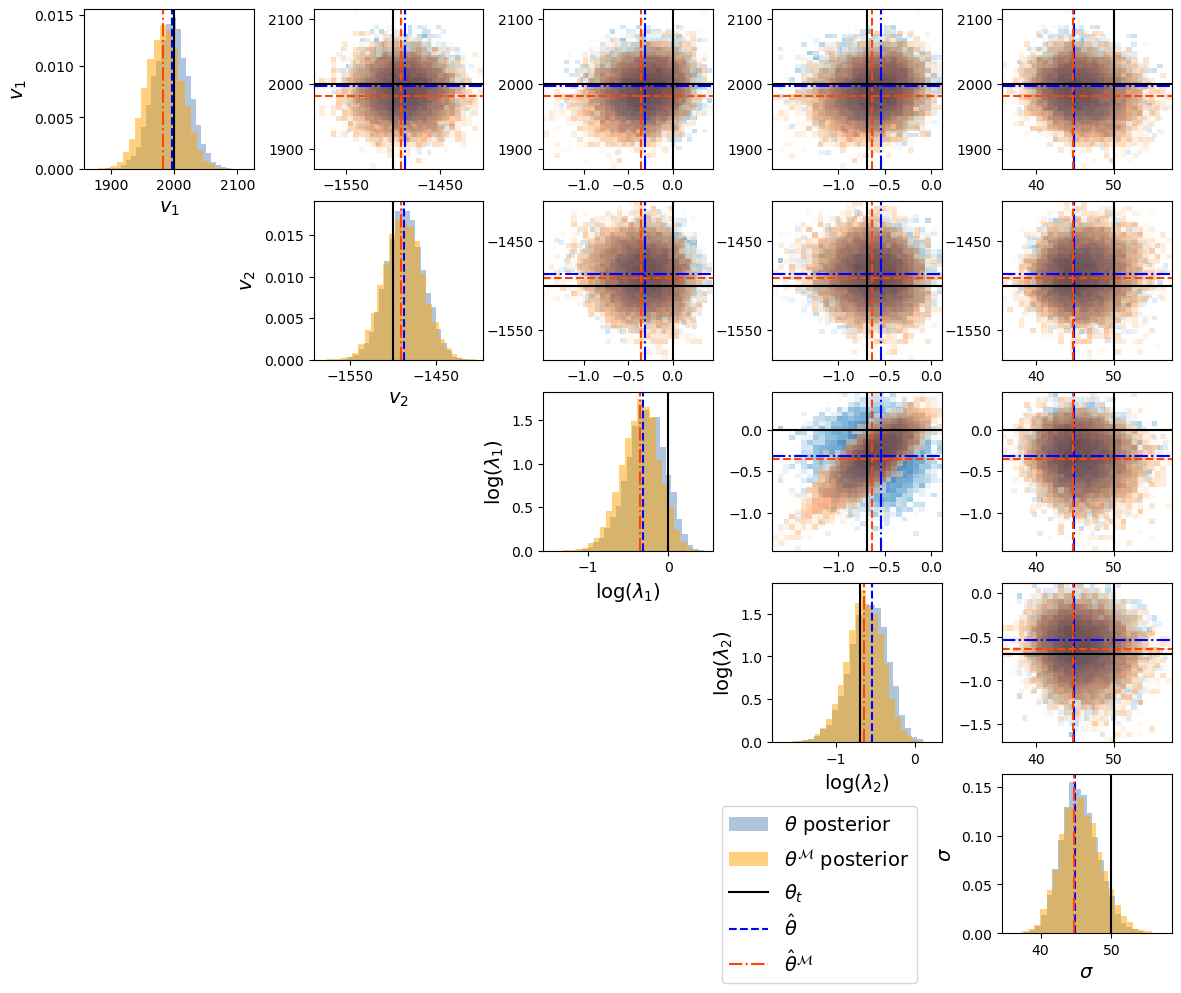

In [7]:
#Figure S2 panel A
fig, ax = plt.subplots(n_param, n_param, figsize=(n_param*2+5,n_param*2+2))
plt.subplots_adjust(wspace=0.35, hspace=0.2)
for i in range(n_param):
    ax[i,i].set_ylabel(parameter_names_tex[i], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i], fontsize=14)

for i in range(n_param):
    ax[i,i].hist(theta_all[i,:], bins=25, alpha=1,
                 label=r'$\theta$ posterior', color='lightsteelblue', density=True)
    ax[i,i].hist(NOT_track_theta_all[i,:], bins=25, alpha=0.5,
                 label=r'$\theta^{\mathcal{M}}$ posterior', color='orange', density=True)
    
    ax[i,i].axvline(theta_true[i], color='black',
                    label=r'$\theta_t$')
    
    best_theta_comp_i = theta_all[i, np.nanargmax(log_pi)]
    ax[i,i].axvline(best_theta_comp_i, linestyle='--', color='blue',
                    label=r'$\hat\theta$')
    NOT_track_best_theta_comp_i = NOT_track_theta_all[i, np.nanargmax(NOT_track_log_pi)]
    ax[i,i].axvline(NOT_track_best_theta_comp_i, linestyle='-.', color='orangered',
                    label=r'$\hat\theta^{\mathcal{M}}$')
    if i==1:
        ax[i,i].set_xticks([-1550, -1450])
for i in range(n_param):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,n_param):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all[j,:], theta_all[i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='Blues')
        ax[i,j].hist2d(NOT_track_theta_all[j,:], NOT_track_theta_all[i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.5, cmap='Oranges')
        
        ax[i,j].axvline(theta_all[j, np.nanargmax(log_pi)], linestyle='-.', color='blue')
        ax[i,j].axvline(NOT_track_theta_all[j, np.nanargmax(NOT_track_log_pi)], linestyle='--', color='orangered')
        
        ax[i,j].axhline(theta_all[i, np.nanargmax(log_pi)], linestyle='-.', color='blue')
        ax[i,j].axhline(NOT_track_theta_all[i, np.nanargmax(NOT_track_log_pi)], linestyle='--', color='orangered')
        
        ax[i,j].axvline(theta_true[j], color='black')
        ax[i,j].axhline(theta_true[i], color='black')
        if j==1 and i==0:
            ax[i,j].set_xticks([-1550, -1450])
        if i==1:
            ax[i,j].set_yticks([-1550, -1450])
        if i==0:
            ax[i,j].set_yticks([1900,2000,2100])
        if j==2 or j==3:
            ax[i,j].set_xticks([-1.0, -0.5, 0.0])

plt.subplots_adjust(right=0.85)
plt.legend(bbox_to_anchor=(-0.50, 0.8), fontsize=14, loc='upper right', borderaxespad=0)
plt.savefig("compare_parameters_posteriors.png", format="png", dpi=1200, bbox_inches="tight")
plt.show()

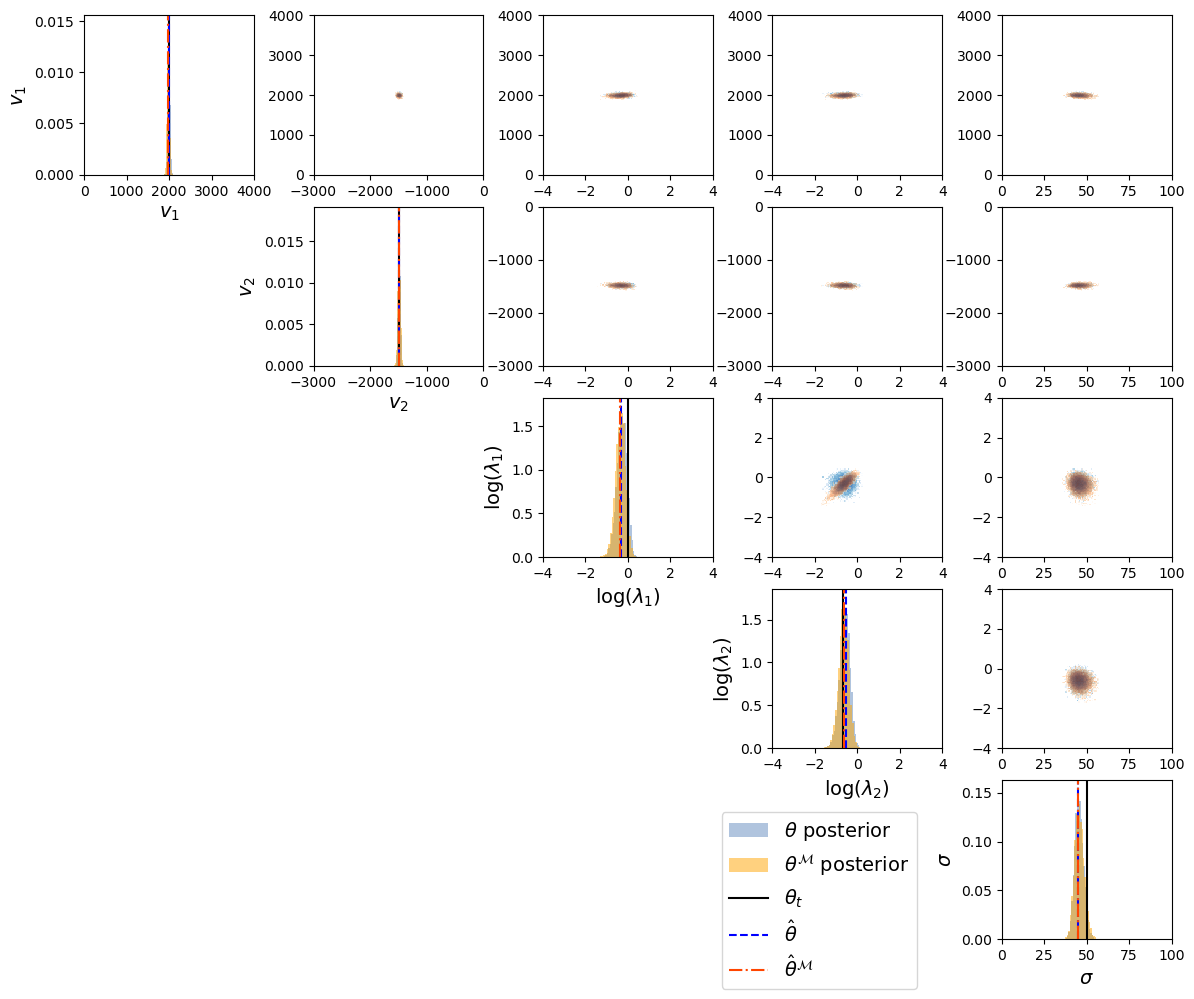

In [8]:
#Figure S3
fig, ax = plt.subplots(n_param, n_param, figsize=(n_param*2+5,n_param*2+2))
plt.subplots_adjust(wspace=0.35, hspace=0.2)
for i in range(n_param):
    ax[i,i].set_ylabel(parameter_names_tex[i], fontsize=14)
    ax[i,i].set_xlabel(parameter_names_tex[i], fontsize=14)

priors = [[0.0, 2.0*V_F], [2.0*V_B, 0.0], [-4.0, 4.0], [-4.0, 4.0], [0.0, 2.0*sigma]]

for i in range(n_param):
    ax[i,i].hist(theta_all[i,:], bins=25, alpha=1,
                 label=r'$\theta$ posterior', color='lightsteelblue', density=True)
    ax[i,i].hist(NOT_track_theta_all[i,:], bins=25, alpha=0.5,
                 label=r'$\theta^{\mathcal{M}}$ posterior', color='orange', density=True)
    ax[i,i].axvline(theta_true[i], color='black',
                    label=r'$\theta_t$')
    best_theta_comp_i = theta_all[i, np.nanargmax(log_pi)]
    ax[i,i].axvline(best_theta_comp_i, linestyle='--', color='blue',
                    label=r'$\hat\theta$')
    NOT_track_best_theta_comp_i = NOT_track_theta_all[i, np.nanargmax(NOT_track_log_pi)]
    ax[i,i].axvline(NOT_track_best_theta_comp_i, linestyle='-.', color='orangered',
                        label=r'$\hat\theta^{\mathcal{M}}$')
    ax[i,i].set_xlim(priors[i])
for i in range(n_param):
    for j in range(0,i):
        ax[i,j].axis('off')
    for j in range(i+1,n_param):
        #plt.title('Checking correlations')
        ax[i,j].hist2d(theta_all[j,:], theta_all[i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.7, cmap='Blues')
        ax[i,j].hist2d(NOT_track_theta_all[j,:], NOT_track_theta_all[i,:], density=True, bins=30,
                       norm=colors.LogNorm(), alpha=0.5, cmap='Oranges')
        ax[i,j].set_xlim(priors[j])
        ax[i,j].set_ylim(priors[i])
        
        #ax[i,j].axvline(theta_all[j, np.nanargmax(log_pi)], linestyle='-.', color='blue')
        #ax[i,j].axvline(NOT_track_theta_all[j, np.nanargmax(NOT_track_log_pi)], linestyle='--', color='orangered')
        
        #ax[i,j].axhline(theta_all[i, np.nanargmax(log_pi)], linestyle='-.', color='blue')
        #ax[i,j].axhline(NOT_track_theta_all[i, np.nanargmax(NOT_track_log_pi)], linestyle='--', color='orangered')
        
        #ax[i,j].axvline(theta_true[j], color='black')
        #ax[i,j].axhline(theta_true[i], color='black')
        
plt.subplots_adjust(right=0.85)
plt.legend(bbox_to_anchor=(-0.50, 0.8), fontsize=14, loc='upper right', borderaxespad=0)
plt.savefig("compare_parameters_posteriors_with_priors.png", format="png", dpi=1200, bbox_inches="tight")
plt.show()

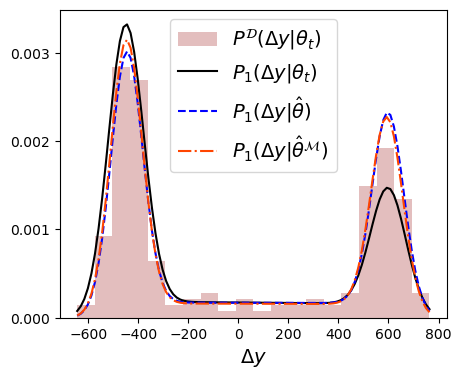

In [9]:
#Figure S2 panel B
eval_points = np.linspace(np.min(delta_y), np.max(delta_y), 100)

nbins = min(int(delta_y.shape[0]/10), 100)

plt.figure(figsize=(5,4))
plt.hist(delta_y, bins=nbins, density=True, alpha=0.3, color='brown', label=r'$P^{\mathcal{D}}(\Delta y | \theta_t)$')
if theta_true is not None:
    approx_pdf_true = approx_pdf_theta(theta_true, get_parameters, delta_t, eval_points, up_to_switches = up_to_switches, track = False)
    plt.plot(eval_points, approx_pdf_true, color='black', label=str(r'$P_1(\Delta y | \theta_t)$'))
if log_pi is not None:
    modes_theta_comp = theta_all[:, np.nanargmax(log_pi)]
    approx_pdf_comp = approx_pdf_theta(modes_theta_comp, get_parameters, delta_t, eval_points, up_to_switches = up_to_switches, track = False)
    plt.plot(eval_points, approx_pdf_comp, '--', color='blue', label=str(r'$P_1(\Delta y | \hat \theta)$'))
    NOT_track_modes_theta_comp = NOT_track_theta_all[:, np.nanargmax(NOT_track_log_pi)]
    NOT_track_approx_pdf_comp = approx_pdf_theta(NOT_track_modes_theta_comp, get_parameters, delta_t, eval_points, up_to_switches = up_to_switches, track = False)
    plt.plot(eval_points, NOT_track_approx_pdf_comp, '-.', color='orangered', label=str(r'$P_1(\Delta y | \hat\theta^{\mathcal{M}})$'))
plt.legend(fontsize=14)
plt.xlabel(r'$\Delta y$', fontsize=14)
plt.yticks([0.000, 0.001, 0.002, 0.003])
plt.savefig("compare_best_fit_compared_to_data.png", format="png", dpi=1200, bbox_inches="tight")